<a href="https://colab.research.google.com/github/GardenHat/ml_exeter_footfall/blob/main/3_split_data_outliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Robin

Last Updated: 25.02.2025

Outline:

File to be Loaded: covid_period_added_combined.parquet

File originated from: 2_initial_data_exploration.ipynb

Data Frame used below: longform_footfall_with_covid_period_df

File Structure:
RangeIndex: 1860 entries, 0 to 1859
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Location            1860 non-null   object        
 1   Date                1860 non-null   datetime64[ns]
 2   Footfall            1860 non-null   int64         
 3   missing_data_check  1860 non-null   object        
 4   is_missing          1860 non-null   int64         
 5   Year                1860 non-null   int32         
 6   covid_time_period   1860 non-null   object        
dtypes: datetime64[ns](1), int32(1), int64(2), object(3)
memory usage: 94.6+ KB

Column details:

#Contents:#
1. Import Libraries
2. Mount Google Drive
3. Load covid_period_added_combined.parquet

In [26]:
# 1. Import Libraries
import pandas as pd
import pyarrow.parquet as pq # for Parquet file
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting
import plotly.graph_objects as go # for interactive plot
from plotly.subplots import make_subplots # for Subplots
from sklearn.cluster import KMeans # kmeans clustering
import plotly.express as px
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster # for clustering charts.
from sklearn.cluster import AgglomerativeClustering # for clustering.
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import squareform




In [27]:
# 2. Mount Google Drive

from google.colab import drive # Goo

# Mount Google Drive and location of files
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [28]:
# 3. Load data
BASE_DIR = '/content/drive/My Drive/machine_learning/data_for_assignment/footfall_data'
file_path = f"{BASE_DIR}/covid_period_added_combined.parquet"
longform_footfall_with_covid_period_df = pq.read_table(file_path).to_pandas()
longform_footfall_with_covid_period_df.info()
longform_footfall_with_covid_period_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860 entries, 0 to 1859
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Location            1860 non-null   object        
 1   Date                1860 non-null   datetime64[ns]
 2   Footfall            1860 non-null   int64         
 3   missing_data_check  1860 non-null   object        
 4   is_missing          1860 non-null   int64         
 5   Year                1860 non-null   int32         
 6   covid_time_period   1860 non-null   object        
dtypes: datetime64[ns](1), int32(1), int64(2), object(3)
memory usage: 94.6+ KB


,Location,Date,Footfall,missing_data_check,is_missing,Year,covid_time_period
0,Cathedral Yard,2017-01-02,58776,footfall_data_present,0,2017,pre_pandemic_period
1,Fore Street,2017-01-02,60150,footfall_data_present,0,2017,pre_pandemic_period
2,Guildhall Shopping Centre,2017-01-02,179342,footfall_data_present,0,2017,pre_pandemic_period
3,High Street At Next,2017-01-02,9011,footfall_data_present,0,2017,pre_pandemic_period
4,High Street Near Guildhall,2017-01-02,143498,footfall_data_present,0,2017,pre_pandemic_period


In [29]:
#4. Unique Values
def display_column_stats(df):
    """
    Display the unique values, their count, and frequency for specified columns.
    """
    columns_to_check = [
        'Location',
        'missing_data_check',
        'is_missing',
        'Year',
        'covid_time_period'
    ]

    for col in columns_to_check:
        if col in df.columns:
            # Get value counts (this shows each unique value and its frequency)
            value_counts = df[col].value_counts().sort_index()
            unique_count = len(value_counts)

            print(f"\n{col}: {unique_count} unique values")
            print(value_counts)
        else:
            print(f"\n{col}: Column not found in dataframe")

# Call the function with the dataframe
display_column_stats(longform_footfall_with_covid_period_df)


Location: 5 unique values
Location
Cathedral Yard                372
Fore Street                   372
Guildhall Shopping Centre     372
High Street At Next           372
High Street Near Guildhall    372
Name: count, dtype: int64

missing_data_check: 2 unique values
missing_data_check
footfall_data_is_missing       1
footfall_data_present       1859
Name: count, dtype: int64

is_missing: 2 unique values
is_missing
0    1859
1       1
Name: count, dtype: int64

Year: 8 unique values
Year
2017    260
2018    265
2019    265
2020    260
2021    260
2022    260
2023    260
2024     30
Name: count, dtype: int64

covid_time_period: 3 unique values
covid_time_period
pandemic_period         525
post_pandemic_period    500
pre_pandemic_period     835
Name: count, dtype: int64


In [30]:
#4. Historgram by location by year.
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
import plotly.express as px
from IPython.display import display, HTML

def plot_footfall_histograms_clean(df, footfall_column='Footfall'):
    """
    Create interactive histograms for each location with cleaner output.
    The histograms display different years as separate traces that can be toggled on/off.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the footfall data with columns:
        'Location', 'Year', and footfall data
    footfall_column : str, optional
        The name of the column containing the footfall data

    Returns:
    --------
    None, displays the plots with minimal console output
    """
    # Get unique locations and years
    locations = sorted(df['Location'].unique())
    years = sorted(df['Year'].unique())

    # Create a color map for years to ensure consistency
    year_colors = {year: px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)]
                  for i, year in enumerate(years)}

    # Suppress verbose output
    display(HTML("<style>pre { white-space: pre !important; overflow-x: scroll !important; }</style>"))

    # Process each location separately with minimal output
    for location in locations:
        # Create a figure for this location
        fig = go.Figure()

        # Filter data for this location
        location_data = df[df['Location'] == location]

        # Define a consistent bin range for this location
        all_footfall = location_data[footfall_column].dropna()
        if len(all_footfall) > 0:
            min_footfall = all_footfall.min()
            max_footfall = all_footfall.max()
            nbins = 20
            bin_size = (max_footfall - min_footfall) / nbins

            # Add a histogram for each year
            for year in years:
                year_data = location_data[location_data['Year'] == year]

                if not year_data.empty and len(year_data) > 0:
                    fig.add_trace(
                        go.Histogram(
                            x=year_data[footfall_column],
                            name=f'Year {year}',
                            opacity=0.6,
                            xbins=dict(
                                start=min_footfall,
                                end=max_footfall,
                                size=bin_size
                            ),
                            marker_color=year_colors[year],
                            histnorm='probability density'  # Normalize for comparison
                        )
                    )

            # Update layout for this location's figure
            fig.update_layout(
                title=f'Footfall Distribution for {location}',
                xaxis_title='Footfall',
                yaxis_title='Density',
                barmode='overlay',
                height=500,
                width=800,
                # Place legend at the bottom
                legend=dict(
                    orientation="h",
                    yanchor="top",
                    y=-0.15,
                    xanchor="center",
                    x=0.5,
                    # Sort items by year
                    traceorder="normal"
                ),
                # Improve the appearance
                plot_bgcolor='white',
                margin=dict(t=50, b=100, l=50, r=50)
            )

            # No instructional annotation

            # Hide verbose output and just show the figure
            fig.show(config={'displayModeBar': True,
                            'displaylogo': False,
                            'modeBarButtonsToRemove': ['select2d', 'lasso2d']})

        # Add a small spacer between plots
        display(HTML("<div style='height: 20px;'></div>"))

# Execute with the dataframe
print("Generating histograms for each location with toggleable year selection...")
plot_footfall_histograms_clean(longform_footfall_with_covid_period_df)
print("All histograms have been displayed.")

Generating histograms for each location with toggleable year selection...


All histograms have been displayed.


In [22]:
# 4. Histograms by COVID Period

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
import plotly.express as px
from IPython.display import display, HTML

def plot_footfall_histograms_by_covid_period(df, footfall_column='Footfall'):
    """
    Create interactive histograms for each location with cleaner output.
    The histograms display different COVID periods as separate traces that can be toggled on/off.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the footfall data with columns:
        'Location', 'covid_time_period', and footfall data
    footfall_column : str, optional
        The name of the column containing the footfall data

    Returns:
    --------
    None, displays the plots with minimal console output
    """
    # Get unique locations and COVID periods
    locations = sorted(df['Location'].unique())
    covid_periods = sorted(df['covid_time_period'].unique())

    # Create a color map for COVID periods to ensure consistency
    # Use a different color palette that might better represent different periods
    period_colors = {period: px.colors.qualitative.Bold[i % len(px.colors.qualitative.Bold)]
                    for i, period in enumerate(covid_periods)}

    # Suppress verbose output
    display(HTML("<style>pre { white-space: pre !important; overflow-x: scroll !important; }</style>"))

    # Process each location separately with minimal output
    for location in locations:
        # Create a figure for this location
        fig = go.Figure()

        # Filter data for this location
        location_data = df[df['Location'] == location]

        # Define a consistent bin range for this location
        all_footfall = location_data[footfall_column].dropna()
        if len(all_footfall) > 0:
            min_footfall = all_footfall.min()
            max_footfall = all_footfall.max()
            nbins = 20
            bin_size = (max_footfall - min_footfall) / nbins

            # Add a histogram for each COVID period
            for period in covid_periods:
                period_data = location_data[location_data['covid_time_period'] == period]

                if not period_data.empty and len(period_data) > 0:
                    fig.add_trace(
                        go.Histogram(
                            x=period_data[footfall_column],
                            name=period,  # Use the period name directly
                            opacity=0.6,
                            xbins=dict(
                                start=min_footfall,
                                end=max_footfall,
                                size=bin_size
                            ),
                            marker_color=period_colors[period],
                            histnorm='probability density'  # Normalize for comparison
                        )
                    )

            # Update layout for this location's figure
            fig.update_layout(
                title=f'Footfall Distribution for {location} by COVID Period',
                xaxis_title='Footfall',
                yaxis_title='Density',
                barmode='overlay',
                height=500,
                width=800,
                # Place legend at the bottom
                legend=dict(
                    orientation="h",
                    yanchor="top",
                    y=-0.15,
                    xanchor="center",
                    x=0.5,
                    # Sort items by period
                    traceorder="normal"
                ),
                # Improve the appearance
                plot_bgcolor='white',
                margin=dict(t=50, b=100, l=50, r=50)
            )

            # Hide verbose output and just show the figure
            fig.show(config={'displayModeBar': True,
                            'displaylogo': False,
                            'modeBarButtonsToRemove': ['select2d', 'lasso2d']})

        # Add a small spacer between plots
        display(HTML("<div style='height: 20px;'></div>"))

# Execute with the dataframe
print("Generating histograms for each location with toggleable COVID period selection...")
plot_footfall_histograms_by_covid_period(longform_footfall_with_covid_period_df)
print("All histograms have been displayed.")

Generating histograms for each location with toggleable COVID period selection...


All histograms have been displayed.


In [31]:
# 4. More bins
# "μ" is used as an abbreviation for "micro.", because the footfall is so high and the averages need to add to 1.
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import plotly.express as px
from IPython.display import display, HTML

def plot_detailed_histograms_by_covid_period(df, footfall_column='Footfall', num_bins=200):
    """
    Create interactive histograms with a large number of bins for each location.
    The histograms display different COVID periods as separate traces that can be toggled on/off.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the footfall data
    footfall_column : str, optional
        The name of the column containing the footfall data
    num_bins : int, optional
        Number of bins to use in the histograms (default: 200 for high detail)
    """
    # Get unique locations and COVID periods
    locations = sorted(df['Location'].unique())
    covid_periods = sorted(df['covid_time_period'].unique())

    # Create a color map for COVID periods
    period_colors = {period: px.colors.qualitative.Bold[i % len(px.colors.qualitative.Bold)]
                    for i, period in enumerate(covid_periods)}

    # Suppress verbose output
    display(HTML("<style>pre { white-space: pre !important; overflow-x: scroll !important; }</style>"))

    # Process each location separately
    for location in locations:
        # Create a figure for this location
        fig = go.Figure()

        # Filter data for this location
        location_data = df[df['Location'] == location]

        # Get global min and max for consistent binning
        all_footfall = location_data[footfall_column].dropna()
        if len(all_footfall) > 0:
            min_footfall = all_footfall.min()
            max_footfall = all_footfall.max()

            # Create explicit bin edges for high resolution
            bin_edges = np.linspace(min_footfall, max_footfall, num_bins + 1)

            # Add a histogram for each COVID period using the explicit bins
            for period in covid_periods:
                period_data = location_data[location_data['covid_time_period'] == period]

                if not period_data.empty and len(period_data) > 0:
                    # Pre-compute the histogram data for more control
                    hist, bin_edges = np.histogram(
                        period_data[footfall_column].dropna(),
                        bins=bin_edges,
                        density=True
                    )

                    # Use a bar chart to display the histogram with precise control
                    fig.add_trace(
                        go.Bar(
                            x=[(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges)-1)],
                            y=hist,
                            name=period,
                            opacity=0.7,
                            marker_color=period_colors[period],
                            width=(bin_edges[1] - bin_edges[0]) * 0.9,  # Slightly narrower than bin width
                        )
                    )

            # Update layout
            fig.update_layout(
                title=f'High-Resolution Footfall Distribution for {location} by COVID Period',
                xaxis_title='Footfall',
                yaxis_title='Density',
                barmode='overlay',
                height=500,
                width=800,
                legend=dict(
                    orientation="h",
                    yanchor="top",
                    y=-0.15,
                    xanchor="center",
                    x=0.5,
                    traceorder="normal"
                ),
                bargap=0,  # Remove gaps between bars
                bargroupgap=0,  # Remove gaps between bar groups
                plot_bgcolor='white',
                margin=dict(t=50, b=100, l=50, r=50)
            )

            # Show the figure
            fig.show(config={'displayModeBar': True,
                            'displaylogo': False,
                            'modeBarButtonsToRemove': ['select2d', 'lasso2d']})

        # Add a small spacer between plots
        display(HTML("<div style='height: 20px;'></div>"))

# Execute with the dataframe
print(f"Generating high-resolution histograms with 200 bins for each location...")
plot_detailed_histograms_by_covid_period(longform_footfall_with_covid_period_df, num_bins=200)
print("All histograms have been displayed.")

Generating high-resolution histograms with 200 bins for each location...


All histograms have been displayed.


#4. Analysis of Histograms
#Cathedral Yard
##many bins
pandemic -looks uniform
post and pre -more bell shapish
pre pandemic to the left of post
##fewer bins
pandemic bellish with right tail
post and pre pandemic bellish with right tail

#Fore Street
##many bins
bell shaped for all
pandemic to the right, then post to the right, then pre to the right
pre pandemic has huge outlier
##fewer bins
pandemic uniformed with right tale
post pandemic uniformed with left tale
pre pandemic uniformedish

#Guildhall shopping Centre
##many bins
pandemic -bell ish
pre and post  pandemic have a tale on right SUMMARISED
##fewer bins
uniformish but with a bell on the right for pandemic
post and pre pandemic bell shaped and tale on right pre pandemic to the left

#High street at Next
##many bins
pandemic, uniformed ish, maybe bell shape, maybe two peaks
post and pre pandemic bell shaped
pre pandemic bell shape is to the right of post pandemic
##fewer bins
pandemic uniform withbelish shape to right maybe two bells
post and pre bellshsaped, post not as much as pre, pre to the left

#High stree near Guildhall
##many bias
pandemic bell ish shape with tale on left
post and pre pandemic bell shaped, pre pandemic to the right of post
##fewer
two peaks one on the right is higher for pandemic period
post pandemic is bell shaped, pre just to the left.





In [38]:
# 5. STL

import pandas as pd
import numpy as np
import plotly.graph_objects as go
from IPython.display import display, HTML

def perform_manual_decomposition(df, footfall_column='Footfall'):
    """
    Perform a robust manual decomposition of footfall data without relying on STL.
    Uses simple moving averages and period-based analysis to approximate
    trend, seasonal, and residual components.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the weekly footfall data
    footfall_column : str, optional
        The name of the column containing the footfall data
    """
    # Ensure data is properly formatted
    df = df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df['Date']):
        df['Date'] = pd.to_datetime(df['Date'])

    # Sort data
    df = df.sort_values(['Location', 'covid_time_period', 'Date'])

    # Get unique locations
    locations = sorted(df['Location'].unique())

    # Suppress verbose output
    display(HTML("<style>pre { white-space: pre !important; overflow-x: scroll !important; }</style>"))

    # Process each location
    for location in locations:
        print(f"\nAnalyzing footfall for {location}")

        # Filter data for this location
        location_data = df[df['Location'] == location]

        # Create figure
        fig = go.Figure()

        # Convert to time series
        ts = location_data.set_index('Date')[footfall_column]

        # 1. Add original data
        fig.add_trace(
            go.Scatter(
                x=ts.index,
                y=ts.values,
                mode='lines',
                name='Original Footfall',
                line=dict(color='black', width=1)
            )
        )

        # 2. Calculate trend using moving average
        if len(ts) >= 10:
            # Use a window size of 13 for quarter-year trend (for weekly data)
            # or a smaller window if we don't have enough data
            window_size = min(13, len(ts) // 2)
            if window_size % 2 == 0:
                window_size += 1  # Make it odd

            print(f"  Calculating trend with {window_size}-week moving average")
            trend = ts.rolling(window=window_size, center=True).mean()

            # Fill NaN values at the ends
            trend = trend.fillna(method='ffill').fillna(method='bfill')

            # Add trend to plot
            fig.add_trace(
                go.Scatter(
                    x=trend.index,
                    y=trend.values,
                    mode='lines',
                    name=f'Trend ({window_size}-week MA)',
                    line=dict(color='blue', width=2)
                )
            )

            # 3. Extract seasonal component using monthly averages
            try:
                print("  Extracting seasonal component based on month of year")

                # Calculate detrended series
                detrended = ts - trend

                # Group by month and calculate average deviation
                detrended_by_month = {}
                for month in range(1, 13):
                    month_mask = detrended.index.month == month
                    if month_mask.any():
                        detrended_by_month[month] = detrended[month_mask].mean()

                # Create seasonal component
                seasonal = pd.Series(index=ts.index, dtype=float)
                for i, date in enumerate(ts.index):
                    month = date.month
                    seasonal.iloc[i] = detrended_by_month.get(month, 0)

                # Add seasonal component to plot
                fig.add_trace(
                    go.Scatter(
                        x=seasonal.index,
                        y=seasonal.values,
                        mode='lines',
                        name='Seasonal Component',
                        line=dict(color='green', width=1)
                    )
                )

                # 4. Calculate residual
                residual = ts - trend - seasonal

                # Add residual to plot
                fig.add_trace(
                    go.Scatter(
                        x=residual.index,
                        y=residual.values,
                        mode='lines',
                        name='Residual',
                        line=dict(color='red', width=1, dash='dot')
                    )
                )

            except Exception as e:
                print(f"  Could not calculate seasonal component: {e}")
        else:
            print(f"  Insufficient data for {location} to calculate components")

        # Update layout
        fig.update_layout(
            title=f"Footfall Decomposition for {location}",
            xaxis_title="Date",
            yaxis_title="Footfall",
            height=600,
            width=1000,
            showlegend=True,
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="right",
                x=1
            )
        )

        # Add COVID period annotations
        covid_periods = location_data['covid_time_period'].unique()
        if len(covid_periods) > 1:
            # Find date ranges for each period
            for period in sorted(covid_periods):
                period_data = location_data[location_data['covid_time_period'] == period]
                if len(period_data) > 0:
                    start_date = period_data['Date'].min()
                    end_date = period_data['Date'].max()
                    mid_point = start_date + (end_date - start_date) / 2

                    # Add vertical lines at period boundaries
                    fig.add_vline(
                        x=start_date,
                        line_width=1,
                        line_dash="dash",
                        line_color="gray"
                    )

                    # Add annotations
                    fig.add_annotation(
                        x=mid_point,
                        y=1.05,
                        yref="paper",
                        text=period,
                        showarrow=False,
                        font=dict(color="black", size=10),
                        bgcolor="rgba(255, 255, 255, 0.7)",
                        bordercolor="gray",
                        borderwidth=1,
                        borderpad=4
                    )

        # Show the figure
        fig.show(config={'displayModeBar': True, 'displaylogo': False})

        # Add a small spacer between plots
        display(HTML("<div style='height: 20px;'></div>"))

# Execute decomposition
print("Performing robust manual decomposition for footfall data...")
perform_manual_decomposition(longform_footfall_with_covid_period_df)
print("Decomposition analysis completed.")

Performing robust manual decomposition for footfall data...



Analyzing footfall for Cathedral Yard
  Calculating trend with 13-week moving average
  Extracting seasonal component based on month of year


<ipython-input-38-7656fc607464>:71: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.




Analyzing footfall for Fore Street
  Calculating trend with 13-week moving average
  Extracting seasonal component based on month of year


<ipython-input-38-7656fc607464>:71: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.




Analyzing footfall for Guildhall Shopping Centre
  Calculating trend with 13-week moving average
  Extracting seasonal component based on month of year


<ipython-input-38-7656fc607464>:71: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.




Analyzing footfall for High Street At Next
  Calculating trend with 13-week moving average
  Extracting seasonal component based on month of year


<ipython-input-38-7656fc607464>:71: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.




Analyzing footfall for High Street Near Guildhall
  Calculating trend with 13-week moving average
  Extracting seasonal component based on month of year


<ipython-input-38-7656fc607464>:71: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Decomposition analysis completed.


In [ ]:
# PLOT LINE GRAPHS TO SEE IF ANY SEASONAL DATA


In [40]:
# 5. STL

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import STL
from IPython.display import display, HTML

def perform_clear_stl_decomposition(df, footfall_column='Footfall'):
    """
    Perform STL decomposition by COVID period with clear, interpretable visualizations.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the weekly footfall data
    footfall_column : str, optional
        The name of the column containing the footfall data
    """
    # Ensure data is properly formatted
    df = df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df['Date']):
        df['Date'] = pd.to_datetime(df['Date'])

    # Sort data
    df = df.sort_values(['Location', 'covid_time_period', 'Date'])

    # Get unique locations and periods
    locations = sorted(df['Location'].unique())
    covid_periods = sorted(df['covid_time_period'].unique())

    # Process each location
    for location in locations:
        print(f"\nAnalyzing footfall patterns for {location} by COVID period")

        # Create a figure with clearly separated subplots
        fig = make_subplots(
            rows=len(covid_periods),
            cols=1,
            subplot_titles=[f"{location} - {period}" for period in covid_periods],
            vertical_spacing=0.1
        )

        # Process each COVID period
        for i, period in enumerate(covid_periods):
            # Get current row index (1-based for plotly)
            row = i + 1

            # Filter data for this location and period
            period_data = df[(df['Location'] == location) &
                             (df['covid_time_period'] == period)]

            if len(period_data) >= 10:
                print(f"  Processing {period} period ({len(period_data)} data points)")

                # Prepare time series
                period_data = period_data.sort_values('Date')
                ts = period_data.set_index('Date')[footfall_column]

                # Handle missing values
                if ts.isna().any():
                    ts = ts.interpolate(method='linear')

                # Add original data
                fig.add_trace(
                    go.Scatter(
                        x=ts.index,
                        y=ts.values,
                        mode='lines',
                        name=f'Original ({period})',
                        line=dict(color='black', width=1)
                    ),
                    row=row, col=1
                )

                # Calculate trend with appropriate window
                window = min(13, max(3, len(ts) // 4 * 2 + 1))
                trend = ts.rolling(window=window, center=True).mean()
                trend = trend.ffill().bfill()  # Fill missing values at ends

                # Add trend to plot
                fig.add_trace(
                    go.Scatter(
                        x=trend.index,
                        y=trend.values,
                        mode='lines',
                        name=f'Trend ({period})',
                        line=dict(color='blue', width=2)
                    ),
                    row=row, col=1
                )

                # Try STL decomposition if we have enough data points
                if len(ts) >= 30:  # Need reasonable amount of data for STL
                    try:
                        # Try to find appropriate seasonal period
                        seasonal_period = 7  # Default to weekly
                        if len(ts) >= 53:
                            seasonal_period = 53  # Use annual cycle if possible

                        # STL requires odd seasonal period
                        if seasonal_period % 2 == 0:
                            seasonal_period += 1

                        # Perform decomposition
                        stl = STL(ts, seasonal=seasonal_period, robust=True)
                        result = stl.fit()

                        # Add seasonal component
                        fig.add_trace(
                            go.Scatter(
                                x=ts.index,
                                y=result.seasonal,
                                mode='lines',
                                name=f'Seasonal ({period})',
                                line=dict(color='green', width=1)
                            ),
                            row=row, col=1
                        )

                        # Add residual component
                        fig.add_trace(
                            go.Scatter(
                                x=ts.index,
                                y=result.resid,
                                mode='lines',
                                name=f'Residual ({period})',
                                line=dict(color='red', width=1, dash='dot')
                            ),
                            row=row, col=1
                        )
                    except Exception as e:
                        print(f"    Could not perform full STL decomposition: {e}")

                        # Calculate and show simpler residual (original minus trend)
                        residual = ts - trend
                        fig.add_trace(
                            go.Scatter(
                                x=residual.index,
                                y=residual.values,
                                mode='lines',
                                name=f'Residual ({period})',
                                line=dict(color='red', width=1, dash='dot')
                            ),
                            row=row, col=1
                        )
                else:
                    print(f"    Not enough data for full decomposition (need 30+, have {len(ts)})")
                    # Just show trend for short series
            else:
                print(f"  Insufficient data for {period} (only {len(period_data)} points)")
                # Add placeholder for empty period
                fig.add_trace(
                    go.Scatter(
                        x=[period_data['Date'].min(), period_data['Date'].max()],
                        y=[0, 0],
                        mode='lines',
                        name=f'Insufficient data ({period})',
                        line=dict(color='gray', width=1, dash='dash')
                    ),
                    row=row, col=1
                )

            # Add y-axis title
            fig.update_yaxes(title_text="Footfall", row=row, col=1)

        # Update layout with more space at bottom for legend
        fig.update_layout(
            height=300 * len(covid_periods) + 50,  # Add 50px for legend space
            width=1000,
            title_text=f"Footfall Patterns for {location} by COVID Period",
            showlegend=True,
            legend=dict(
                orientation="h",
                yanchor="top",
                y=-0.05 / len(covid_periods),  # Scale based on number of periods
                xanchor="center",
                x=0.5
            ),
            margin=dict(b=80)  # Add more bottom margin for legend
        )

        # Show the figure
        fig.show(config={'displayModeBar': True, 'displaylogo': False})

        # Add spacing between locations
        display(HTML("<div style='height: 20px;'></div>"))

# Execute decomposition
print("Performing clear STL decomposition by COVID period...")
perform_clear_stl_decomposition(longform_footfall_with_covid_period_df)
print("Analysis completed.")

Performing clear STL decomposition by COVID period...

Analyzing footfall patterns for Cathedral Yard by COVID period
  Processing pandemic_period period (105 data points)
  Processing post_pandemic_period period (100 data points)
  Processing pre_pandemic_period period (167 data points)
    Could not perform full STL decomposition: Unable to determine period from endog



Analyzing footfall patterns for Fore Street by COVID period
  Processing pandemic_period period (105 data points)
  Processing post_pandemic_period period (100 data points)
  Processing pre_pandemic_period period (167 data points)
    Could not perform full STL decomposition: Unable to determine period from endog



Analyzing footfall patterns for Guildhall Shopping Centre by COVID period
  Processing pandemic_period period (105 data points)
  Processing post_pandemic_period period (100 data points)
  Processing pre_pandemic_period period (167 data points)
    Could not perform full STL decomposition: Unable to determine period from endog



Analyzing footfall patterns for High Street At Next by COVID period
  Processing pandemic_period period (105 data points)
  Processing post_pandemic_period period (100 data points)
  Processing pre_pandemic_period period (167 data points)
    Could not perform full STL decomposition: Unable to determine period from endog



Analyzing footfall patterns for High Street Near Guildhall by COVID period
  Processing pandemic_period period (105 data points)
  Processing post_pandemic_period period (100 data points)
  Processing pre_pandemic_period period (167 data points)
    Could not perform full STL decomposition: Unable to determine period from endog


Analysis completed.


In [43]:
# 5. STL

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import STL
from IPython.display import display, HTML

def prepare_data_for_stl(df):
    """
    Prepare the dataframe for STL decomposition by ensuring date is in datetime format
    """
    df_copy = df.copy()

    # Ensure Date column is datetime
    if 'Date' in df_copy.columns and not pd.api.types.is_datetime64_any_dtype(df_copy['Date']):
        df_copy['Date'] = pd.to_datetime(df_copy['Date'])

    return df_copy

def perform_stl_decomposition(df, footfall_column='Footfall', period=53):
    """
    Perform STL decomposition on weekly footfall data for each location and COVID period.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the weekly footfall data with columns:
        'Location', 'Date', 'covid_time_period', and footfall data
    footfall_column : str, optional
        The name of the column containing the footfall data
    period : int, optional
        The periodicity of the seasonal component (default: 53 for weekly data to ensure odd number)

    Returns:
    --------
    None, displays the decomposition plots
    """
    # Ensure the dataframe is sorted by date
    df = df.sort_values(['Location', 'Date'])

    # Get unique locations and COVID periods
    locations = sorted(df['Location'].unique())
    covid_periods = sorted(df['covid_time_period'].unique())

    # Explicitly convert date column to datetime if needed
    if not pd.api.types.is_datetime64_any_dtype(df['Date']):
        df['Date'] = pd.to_datetime(df['Date'])

    # Ensure data is sorted chronologically
    df = df.sort_values(['Location', 'covid_time_period', 'Date'])

    # Suppress verbose output
    display(HTML("<style>pre { white-space: pre !important; overflow-x: scroll !important; }</style>"))

    # Process each location
    for location in locations:
        print(f"\nPerforming STL decomposition for {location}")

        # Create a figure for this location with subplots for each COVID period
        fig = make_subplots(
            rows=len(covid_periods),
            cols=1,
            subplot_titles=[f"{location} - {period}" for period in covid_periods],
            vertical_spacing=0.1,
            specs=[[{"secondary_y": False}] for _ in range(len(covid_periods))]
        )

        # Process each COVID period for this location
        for i, period_name in enumerate(covid_periods):
            # Get current row (1-indexed for plotly)
            current_row = i + 1
            # Filter data for this location and COVID period
            period_data = df[(df['Location'] == location) &
                             (df['covid_time_period'] == period_name)]

            # If there's enough data, perform decomposition
            if len(period_data) >= 10:  # Require at least 10 data points
                # Convert to time series with explicit frequency
                try:
                    # Ensure date is sorted and set as index
                    period_data = period_data.sort_values('Date')
                    ts = period_data.set_index('Date')[footfall_column]

                    # Ensure the index is datetime with frequency
                    if not isinstance(ts.index, pd.DatetimeIndex):
                        ts.index = pd.to_datetime(ts.index)

                    # Explicitly reindex to weekly frequency if needed
                    if ts.index.freq is None:
                        # Create a complete date range at weekly frequency
                        date_range = pd.date_range(
                            start=ts.index.min(),
                            end=ts.index.max(),
                            freq='W'  # Weekly frequency
                        )
                        # Reindex the series to ensure regular frequency
                        ts = ts.reindex(date_range)

                    # Handle missing values
                    if ts.isna().any():
                        print(f"  Filling {ts.isna().sum()} missing values for {period_name}")
                        ts = ts.interpolate(method='linear')

                    try:
                        # Use a simpler approach for pre_pandemic_period
                        if period_name == 'pre_pandemic_period':
                            # Use a simple moving average for trend
                            window_size = min(13, len(ts) // 2)
                            if window_size % 2 == 0:
                                window_size += 1  # Make it odd

                            print(f"  Using simple decomposition for {period_name} with window size {window_size}")

                            # Compute trend using moving average
                            trend = ts.rolling(window=window_size, center=True).mean()
                            # Fill the ends where rolling mean creates NaN
                            trend = trend.fillna(method='bfill').fillna(method='ffill')

                            # Seasonal component (simplified)
                            # Group by month and get average deviation from trend
                            month_indices = ts.index.month
                            monthly_averages = {}

                            for month in range(1, 13):
                                if month in month_indices:
                                    month_mask = ts.index.month == month
                                    if month_mask.any():
                                        monthly_averages[month] = (ts[month_mask] - trend[month_mask]).mean()

                            # Create seasonal component
                            seasonal = pd.Series(index=ts.index, dtype=float)
                            for i, date in enumerate(ts.index):
                                month = date.month
                                seasonal.iloc[i] = monthly_averages.get(month, 0)

                            # Residual component
                            residual = ts - trend - seasonal
                        else:
                            # Ensure we have a valid seasonal period (must be odd)
                            seasonal_period = period
                            if seasonal_period % 2 == 0:
                                seasonal_period += 1  # Make it odd

                            # For short series, reduce the seasonal period
                            if len(ts) < 2 * seasonal_period:
                                # Try to find a smaller odd period that fits the data
                                for smaller_period in [13, 11, 7, 5, 3]:
                                    if len(ts) >= 2 * smaller_period:
                                        seasonal_period = smaller_period
                                        print(f"  Reduced seasonal period to {seasonal_period} for {period_name} due to limited data")
                                        break

                            # Perform STL decomposition with the appropriate period
                            stl = STL(ts, seasonal=seasonal_period, robust=True)
                            result = stl.fit()

                            # Extract components
                            trend = result.trend
                            seasonal = result.seasonal
                            residual = result.resid

                            fig.add_trace(
                                go.Scatter(
                                    x=ts.index,
                                    y=ts.values,
                                    mode='lines',
                                    name='Original',
                                    line=dict(color='black', width=1)
                                ),
                                row=current_row, col=1
                            )

                            fig.add_trace(
                                go.Scatter(
                                    x=ts.index,
                                    y=trend,
                                    mode='lines',
                                    name='Trend',
                                    line=dict(color='blue', width=2)
                                ),
                                row=current_row, col=1
                            )

                            fig.add_trace(
                                go.Scatter(
                                    x=ts.index,
                                    y=seasonal,
                                    mode='lines',
                                    name='Seasonal',
                                    line=dict(color='green', width=1)
                                ),
                                row=current_row, col=1
                            )

                            fig.add_trace(
                                go.Scatter(
                                    x=ts.index,
                                    y=residual,
                                    mode='lines',
                                    name='Residual',
                                    line=dict(color='red', width=1, dash='dot')
                                ),
                                row=current_row, col=1
                            )

                    except Exception as e:
                        print(f"  Error performing decomposition for {period_name}: {e}")
                        # Add empty trace with error message
                        fig.add_trace(
                            go.Scatter(
                                x=[period_data['Date'].min(), period_data['Date'].max()],
                                y=[0, 0],
                                mode='lines',
                                name='Error',
                                line=dict(color='red', width=2)
                            ),
                            row=current_row, col=1
                        )

                except Exception as e:
                    print(f"  Error preparing time series for {period_name}: {e}")
                    # Add empty trace with error message
                    fig.add_trace(
                        go.Scatter(
                            x=[period_data['Date'].min(), period_data['Date'].max()],
                            y=[0, 0],
                            mode='lines',
                            name='Error',
                            line=dict(color='red', width=2)
                        ),
                        row=i+1, col=1
                    )
            else:
                print(f"  Insufficient data for {period_name} (needs at least 10 points, has {len(period_data)})")
                # Add empty trace with message
                fig.add_trace(
                    go.Scatter(
                        x=[period_data['Date'].min(), period_data['Date'].max()],
                        y=[period_data[footfall_column].mean(), period_data[footfall_column].mean()],
                        mode='lines',
                        name='Insufficient Data',
                        line=dict(color='gray', width=2, dash='dash')
                    ),
                    row=i+1, col=1
                )

                # If we have some data, at least plot it
                if len(period_data) > 0:
                    fig.add_trace(
                        go.Scatter(
                            x=period_data['Date'],
                            y=period_data[footfall_column],
                            mode='lines',
                            name='Original Data',
                            line=dict(color='black', width=1)
                        ),
                        row=i+1, col=1
                    )

        # Update layout
        fig.update_layout(
            height=300 * len(covid_periods),
            width=1000,
            title_text=f"STL Decomposition for {location} by COVID Period",
            showlegend=True,
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="right",
                x=1
            )
        )

        # Update y-axis titles
        for i in range(1, len(covid_periods) + 1):
            fig.update_yaxes(title_text="Footfall", row=i, col=1)

        # Show the figure
        fig.show(config={'displayModeBar': True,
                        'displaylogo': False})

        # Add a small spacer between location plots
        display(HTML("<div style='height: 20px;'></div>"))

# Main execution code
print("Performing STL Decomposition for weekly footfall data by COVID period...")

# Prepare the data
prepared_df = prepare_data_for_stl(longform_footfall_with_covid_period_df)

# Perform decomposition with adjusted seasonality (53 weeks to ensure odd number)
perform_stl_decomposition(prepared_df, period=53)

print("STL Decomposition completed.")

Performing STL Decomposition for weekly footfall data by COVID period...



Performing STL decomposition for Cathedral Yard
  Filling 104 missing values for pandemic_period
  Reduced seasonal period to 13 for pandemic_period due to limited data
  Filling 99 missing values for post_pandemic_period
  Reduced seasonal period to 13 for post_pandemic_period due to limited data
  Filling 165 missing values for pre_pandemic_period
  Using simple decomposition for pre_pandemic_period with window size 13


<ipython-input-43-e2909ce0ac69>:120: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.




Performing STL decomposition for Fore Street
  Filling 104 missing values for pandemic_period
  Reduced seasonal period to 13 for pandemic_period due to limited data
  Filling 99 missing values for post_pandemic_period
  Reduced seasonal period to 13 for post_pandemic_period due to limited data
  Filling 165 missing values for pre_pandemic_period
  Using simple decomposition for pre_pandemic_period with window size 13


<ipython-input-43-e2909ce0ac69>:120: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.




Performing STL decomposition for Guildhall Shopping Centre
  Filling 104 missing values for pandemic_period
  Reduced seasonal period to 13 for pandemic_period due to limited data
  Filling 99 missing values for post_pandemic_period
  Reduced seasonal period to 13 for post_pandemic_period due to limited data
  Filling 165 missing values for pre_pandemic_period
  Using simple decomposition for pre_pandemic_period with window size 13


<ipython-input-43-e2909ce0ac69>:120: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.




Performing STL decomposition for High Street At Next
  Filling 104 missing values for pandemic_period
  Reduced seasonal period to 13 for pandemic_period due to limited data
  Filling 99 missing values for post_pandemic_period
  Reduced seasonal period to 13 for post_pandemic_period due to limited data


<ipython-input-43-e2909ce0ac69>:120: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



  Filling 165 missing values for pre_pandemic_period
  Using simple decomposition for pre_pandemic_period with window size 13



Performing STL decomposition for High Street Near Guildhall
  Filling 104 missing values for pandemic_period
  Reduced seasonal period to 13 for pandemic_period due to limited data
  Filling 99 missing values for post_pandemic_period
  Reduced seasonal period to 13 for post_pandemic_period due to limited data
  Filling 165 missing values for pre_pandemic_period
  Using simple decomposition for pre_pandemic_period with window size 13


<ipython-input-43-e2909ce0ac69>:120: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



STL Decomposition completed.


https://medium.com/@kis.andras.nandor/demystifying-stl-understanding-seasonal-decomposition-of-time-series-d3c50150ec12


https://mlpills.dev/time-series/time-series-forecasting-with-stl/


https://www.youtube.com/watch?v=mk0j1w1DsZM



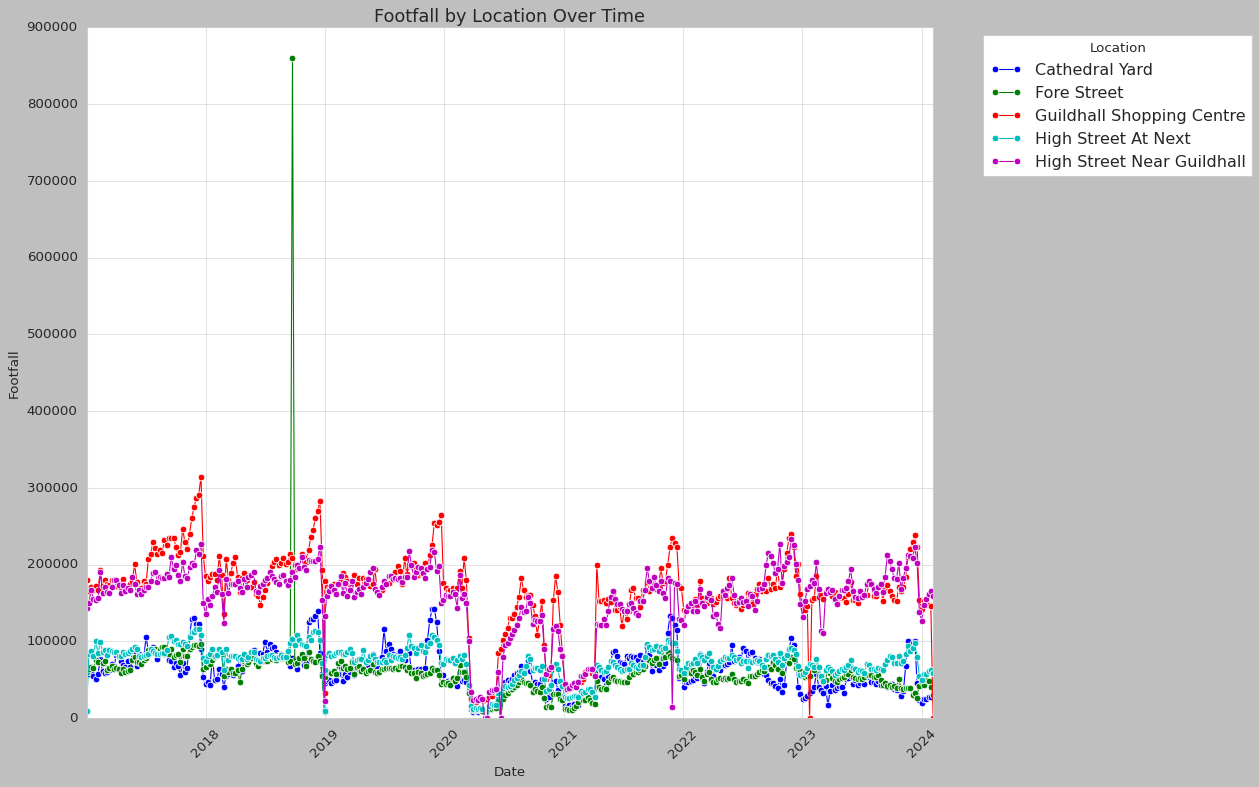

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_footfall_by_location(df):
    """
    Visualize Footfall by Location across Date using Seaborn line plot
    Optimized for Colab notebook display

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing 'Date' and 'Footfall' columns, with a 'Location' column for grouping
    """
    # Set up the plot
    plt.figure(figsize=(16, 10))
    sns.set_style("whitegrid")

    # Create a line plot
    sns.lineplot(
        data=df,
        x='Date',
        y='Footfall',
        hue='Location',
        marker='o'  # Add markers to data points
    )

    # Customize the plot
    plt.title('Footfall by Location Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Footfall', fontsize=12)
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

visualize_footfall_by_location(longform_footfall_with_covid_period_df)